In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def plot_traces(datas, smoothing=1, **kwargs):
    plt.figure()
    sds = kwargs.get('sd', None)
    labels = kwargs.get('labels', [None]*len(datas))
    for i in range(len(datas)):
        data = datas[i]
        smoothed_data = running_mean(data,smoothing)
        plt.plot(smoothed_data, label=labels[i])

        if sds is not None:
            sd = sds[i]
            error = running_mean(sd,smoothing)
            plt.fill_between(np.arange(len(smoothed_data)), smoothed_data-error, smoothed_data+error, alpha=0.25)
    if labels[0] is not None:
        plt.legend(bbox_to_anchor=(1.01,1), loc='upper left', borderaxespad=0.0)
    plt.ylim([-3, 1.5])
    plt.show()
    plt.close()

class data_filter(object):
    def __init__(self, df, **kwargs):
        self.exp_type    = kwargs.get('expt_type',       df['Experiment_Type'].unique()) #list of strings
        self.env_type    = kwargs.get('env_type',        ['Openfield']) #df['Env_Type'].unique()) #string
        self.dims        = kwargs.get('dims',            df['Dimensions'].unique()) #string
        self.num_actions = kwargs.get('num_actions',     [4]) #df['Num_Actions'].unique()) # int
        self.rwd_action  = kwargs.get('rewarded_action', ['None']) # df['Rewarded_Action'].unique()) # string
        self.rho         = kwargs.get('rho',             df['Rho'].unique()) # float
        self.arch        = kwargs.get('arch',            df['Architecture'].unique()) # list of strings
        self.ec_entropy  = kwargs.get('ec_entropy',      df['EC_Entropy'].unique()) #string ?!?!?!
        self.pvals       = kwargs.get('p_vals',          df['Pvals'].unique()) # bool

        self.info = self.filter_df(df)
        print(f'{self.info.shape[0]}/{df.shape[0]} entries match criteria')
        if self.info.shape[0] == 0:
            raise Exception("No Data to Collect")
        self.ids = self.info['Run_ID']
        self.data = self.get_data()

        self.reward_avg, self.reward_sd = self.average('total_reward')

    def filter_df(self, df):
        idx = np.where((df['Experiment_Type'].isin(self.exp_type))
                       & (df['Env_Type'].isin(self.env_type))
                       & (df['Dimensions'].isin(self.dims))
                       & (df['Num_Actions'].isin(self.num_actions))
                       & (df['Rewarded_Action'].isin(self.rwd_action))
                       & (df['Rho'].isin(self.rho))
                       & (df['Architecture'].isin(self.arch))
                       & (df['EC_Entropy'].isin(self.ec_entropy))
                       & (df['Pvals'].isin(self.pvals))
                      )
        filtered_info = df.loc[idx]

        return filtered_info

    def get_data(self):
        data = []
        for ii, id_ in enumerate(self.ids):
            data.append(pickle.load(open(f'../data/outputs/gridworld/results/{id_}_data.p', 'rb')))
        return data

    def average(self, data_type='total_reward', **kwargs):
        start_ind = kwargs.get('start_ind', 0)
        end_ind   = kwargs.get('end_ind', -1)

        data_to_average = []
        array_lengths = [len(i[data_type]) for i in self.data]
        masked_array = np.ma.empty((len(self.data),np.max(array_lengths)))
        masked_array.mask = True

        for idx, i in enumerate(self.data):
            masked_array[idx,:len(i[data_type])] = i[data_type]

        return masked_array.mean(axis=0), masked_array.std(axis=0)

In [3]:
df = pd.read_csv("../data/outputs/gridworld/experiments.csv")

In [4]:
B_train = data_filter(df, expt_type=[0], arch=['B'])
B_MF    = data_filter(df, expt_type=[1], arch=['B'])
print('-----')
B_psi   = data_filter(df, expt_type=[2], arch=['B'], ec_entropy=[0.1])
#B_phi   = data_filter(df, expt_type=[3], arch=['B'])
B_MF_free = data_filter(df, expt_type=[4], arch=['B'])
B_psi_free = data_filter(df, expt_type=[5], arch=['B'],ec_entropy=[0.1])
#B_phi_free = data_filter(df, expt_type=[6], arch=['B'])

13/127 entries match criteria
4/127 entries match criteria
-----
5/127 entries match criteria
6/127 entries match criteria
7/127 entries match criteria


In [7]:
for i in B_MF.info['Run_ID']:
    print(i)

d0d1fc3c-a4d0-47cc-aaa3-3a7628b48d96
25aea97f-8e6d-41db-bf01-7735544926d1
aefbcf68-d71c-43c7-96f8-57a8b018e9ec
e5f1d2a5-6070-4106-ad68-a766663ecf27


In [8]:
smoothing = 100
training_data = running_mean(B_train.reward_avg[0:5000], smoothing)
test_mf = running_mean(B_MF.reward_avg, smoothing)
#test_phi = running_mean(B_phi.reward_avg, smoothing)
test_psi = running_mean(B_psi.reward_avg, smoothing)
test_mff = running_mean(B_MF_free.reward_avg, smoothing)
#test_phif = running_mean(B_phi_free.reward_avg, smoothing)
test_psif = running_mean(B_psi_free.reward_avg, smoothing)

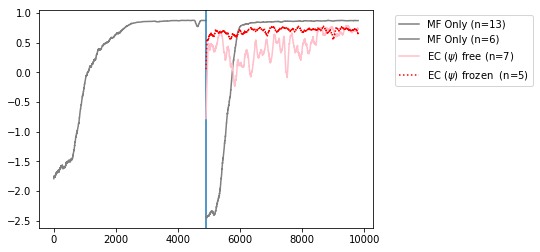

In [9]:
plt.plot(training_data, 'gray', label=f'MF Only (n={B_train.info.shape[0]})' )
plt.axvline(x=len(training_data))

plt.plot(len(training_data)+np.arange(len(test_mff)),test_mff,'gray', label=f'MF Only (n={B_MF_free.info.shape[0]})')
#plt.plot(len(training_data)+np.arange(len(test_mf)), test_mf, 'green', linestyle=':')

#plt.plot(len(training_data)+np.arange(len(test_phi)), test_phif,'red', label='EC ($\phi$)')
#plt.plot(len(training_data)+np.arange(len(test_phi)), test_phi, 'red', linestyle=':')

plt.plot(len(training_data)+np.arange(len(test_psi)), test_psif, 'pink', label=f'EC ($\psi$) free (n={B_psi_free.info.shape[0]})')
plt.plot(len(training_data)+np.arange(len(test_psi)), test_psi, 'red', linestyle=':', label=f'EC ($\psi$) frozen  (n={B_psi.info.shape[0]})')

plt.legend(bbox_to_anchor=(1.05,1))


In [14]:
A_train = data_filter(df, expt_type=[0], arch=['A'])

A_MF    = data_filter(df, expt_type=[1], arch=['A'])
A_MF_free = data_filter(df, expt_type=[4], arch=['A'])

A_h   = data_filter(df, expt_type=[2], arch=['A'], ec_entropy=[0.1])
A_h_free = data_filter(df, expt_type=[5], arch=['A'],ec_entropy=[0.1])


7/114 entries match criteria
6/114 entries match criteria
3/114 entries match criteria
6/114 entries match criteria
5/114 entries match criteria


In [15]:
smoothing = 100
training_data = running_mean(A_train.reward_avg[0:5000], smoothing)

test_mf = running_mean(A_MF.reward_avg, smoothing)
test_mff = running_mean(A_MF_free.reward_avg, smoothing)

test_h = running_mean(A_h.reward_avg, smoothing)
test_hf = running_mean(A_h_free.reward_avg, smoothing)


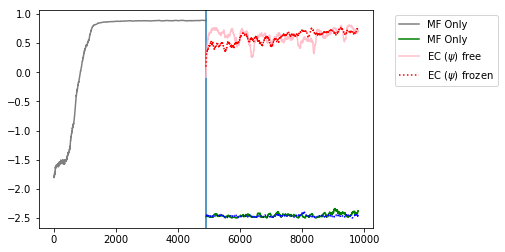

In [17]:
plt.plot(training_data, 'gray', label='MF Only')
plt.axvline(x=len(training_data))

plt.plot(len(training_data)+np.arange(len(test_mff)),test_mff,'green', label='MF Only')
plt.plot(len(training_data)+np.arange(len(test_mf)), test_mf, 'green', linestyle=':')

plt.plot(len(training_data)+np.arange(len(test_h)), test_hf, 'pink', label='EC ($\psi$) free')
plt.plot(len(training_data)+np.arange(len(test_h)), test_h, 'red', linestyle=':', label='EC ($\psi$) frozen')

plt.legend(bbox_to_anchor=(1.05,1))

In [ ]:
training_A = data_filter(df, expt_type=[0], arch=['A'])
training_B = data_filter(df, expt_type=[0], arch=['B'])

plot_traces([training_A.reward_avg, training_B.reward_avg],sd=[training_A.reward_sd, training_B.reward_sd], labels=['A','B'],smoothing=100)

In [ ]:
testing_B1 = data_filter(df, expt_type=[1])
#testing_B2 = data_filter(df, expt_type=[2])
testing_B3 = data_filter(df, expt_type=[3])
_try = [[testing_B1.reward_avg, testing_B3.reward_avg], [testing_B1.reward_sd, testing_B3.reward_sd]]
plot_traces(_try[0],sds=_try[1],labels=['MF only','EC_phi'],smoothing=30)

In [ ]:
experiments = ['Training', 
               'A-MF Only',
               'A-EC Only ($\psi$)',
               'A-EC Only ($\phi$)',
               'B-MF Only',
               'B-EC Only ($\psi$)', 
               'B-EC Only ($\phi$)'
              ]


## Architecture A -- No SR

In [ ]:
A_runs = df.loc[df['Architecture']=='A']
A_training = A_runs.loc[A_runs['Experiment_Type']==0]

In [ ]:
x=A_runs.iloc[0]


print(type(x['Rewarded_Action']))

## Architecture B - with SR

In [ ]:
B_runs = df.loc[df['Architecture']=='A']
B_training = B_runs.loc[(B_runs['Experiment_Type']==0) &(B_runs['Num_Actions']==4)]

data = []
for id_ in B_training['Run_ID']:
    data.append(pickle.load(open(f'../data/outputs/gridworld/results/{id_}_data.p', 'rb')))

### Training - MF Alone

In [ ]:
smoothing = 30
reward = []
for i in data:
    reward.append(i['total_reward'][0:5000])

average_training_reward = np.mean(np.vstack(reward), axis=0)
sd_training_reward      = np.std(np.vstack(reward), axis=0)

plt.plot(running_mean(average_training_reward, smoothing))
plt.fill_between(np.arange(len(average_training_reward)), average_training_reward-sd_training_reward, average_training_reward+sd_training_reward, alpha=0.2)
plt.title(f'Average Total Trial Reward During Training (n={len(reward)})')
plt.ylim([-2.6, 1.5])
plt.show()

### Testing - MF Alone

In [ ]:
B_MF_testing = B_runs.loc[(B_runs['Experiment_Type'].isin([2])) &(B_runs['Num_Actions']==4)]

MF_data = []
for id_ in B_MF_testing['Run_ID']:
    MF_data.append(pickle.load(open(f'../data/outputs/gridworld/results/{id_}_data.p', 'rb')))

MF_reward = []
for i in MF_data:
    MF_reward.append(i['total_reward'][0:2000])

average_MF_reward = running_mean(np.mean(np.vstack(MF_reward), axis=0), smoothing)
sd_MF_reward      = running_mean(np.std(np.vstack(MF_reward), axis=0),smoothing)

### Testing - EC Alone

In [ ]:
B_EC_testing = B_runs.loc[(B_runs['Experiment_Type'].isin([5])) &(B_runs['Num_Actions']==4)]

EC_data = []
for id_ in B_EC_testing['Run_ID']:
    EC_data.append(pickle.load(open(f'../data/outputs/gridworld/results/{id_}_data.p', 'rb')))
    
EC_reward = []
for i in EC_data:
    EC_reward.append(i['total_reward'][0:2000])

average_EC_reward = running_mean(np.mean(np.vstack(EC_reward), axis=0), smoothing)
sd_EC_reward      = running_mean(np.std(np.vstack(EC_reward), axis=0), smoothing)

In [ ]:
plt.figure()
plt.plot(average_MF_reward, label = f'Frozen Weights (n={len(MF_reward)})')
plt.fill_between(np.arange(len(average_MF_reward)), average_MF_reward-sd_MF_reward, average_MF_reward+sd_MF_reward, alpha=0.2)
plt.plot(average_EC_reward, label = f'Unfrozen Weights (n={len(EC_reward)})')
plt.fill_between(np.arange(len(average_EC_reward)), average_EC_reward-sd_EC_reward, average_EC_reward+sd_EC_reward, alpha=0.2)
#plt.fill_between(np.arange(len(average_reward)), average_reward-sd_reward, average_reward+sd_reward, alpha=0.2)
plt.title(f'Average Total Trial Reward During Testing')

plt.ylim([-2.6, 1.5])
plt.legend(loc = 0)
plt.show()

In [ ]:
plt.figure()
plt.plot(average_MF_reward, label = f'Frozen Weights (n={len(MF_reward)})')
plt.fill_between(np.arange(len(average_MF_reward)), average_MF_reward-sd_MF_reward, average_MF_reward+sd_MF_reward, alpha=0.2)
plt.plot(average_EC_reward, label = f'Unfrozen Weights (n={len(EC_reward)})')
plt.fill_between(np.arange(len(average_EC_reward)), average_EC_reward-sd_EC_reward, average_EC_reward+sd_EC_reward, alpha=0.2)
#plt.fill_between(np.arange(len(average_reward)), average_reward-sd_reward, average_reward+sd_reward, alpha=0.2)
plt.title(f'Average Total Trial Reward During Testing')

plt.ylim([-2.6, 1.5])
plt.legend(loc = 0)
plt.show()

In [ ]:
experiment_number = 2
infos = df.loc[df['Experiment_Type'] == experiment_number, ['Run_ID', 'Memory_Policy_Entropy']].sort_values(by='Memory_Policy_Entropy')[10:13]
print(f'Data for {experiments[experiment_number]}\n',infos)

In [ ]:
ids = infos.values[0:10,0]
entropys = infos.values[0:10,1]

In [ ]:
data = []
for id_num in ids:
    data.append(pickle.load(open(f'../data/outputs/gridworld/{id_num}_data.p', 'rb')))

In [ ]:
#data3 = data
smoothing = 100
for i in range(int(len(data))):
    index = i
    plt.plot(running_mean(data[index]['total_reward'], smoothing), 'r', label = entropys[index])
    plt.plot(running_mean(data3[index]['total_reward'], smoothing),'c', label = entropys[index])
plt.ylim(0, 1.1)
plt.xlim([-50,1850])
plt.legend(loc=0)
plt.show()


In [ ]:
ec_only = data[-1]['total_reward']

In [ ]:
d = []
for i in range(len(data)):
    d.append(data[i]['total_reward'][0:5000])

In [ ]:
mean_MF = np.mean(np.vstack(d),axis=0)

In [ ]:
smoothing = 30
plt.plot(running_mean(mean_MF, smoothing), label = 'MF_only')
plt.plot(running_mean(ec_only, smoothing), label = 'EC_only')
plt.title("Post Training Moved Reward Performance")
plt.legend(loc=0)

In [ ]:
#junkyard
#-----------------------------------------
# read in experimental ID from CSV file 
experiments = [[],[],[],[],[],[]]
with open("../data/outputs/gridworld/experiments.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter =',',quotechar='|', quoting=csv.QUOTE_MINIMAL) 
    for row in reader:
        if row[1]=='Experiment_Type':
            pass
        else:
            experiments[int(row[1])].append(row[0])
print(experiments)